$\DeclareMathOperator*{\argmin}{arg~min}$
$\def\R{\mathbb{R}}$

# Bayesian Optimization of Combinatorial Structures (simplified ver.)

本ノートブックではアニーリング法を用いた Bayesian Optimization of Combinatorial Structures (`BOCS-SA`) [Baptista + Poloczek] の簡略版を実装する。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from julia import Main
from typing import Callable, Optional
from IPython.display import display, clear_output

dir_script = Path(os.getcwd())

## 参考文献

- [Baptista + Poloczek (2018)] R. Baptista and M. Poloczek, Bayesian Optimization of Combinatorial Structures, in Proceedings of the 35th International Conference on Machine Learning, edited by J. Dy and A. Krause, Vol. 80 (PMLR, 2018), pp. 462–471.

## ベイズ最適化

ベイズ最適化は、高コストかつ内部構造が不明な目的関数の最適化のための手法である。各ステップで目的関数の内部構造を推定し、その推定結果を用いて次の探索点 $x$ を決める。決まった探索点 $x$ で実際に目的関数を評価し、観測値 $y$ を得る。こうして得られた入出力ペア $(x, y)$ を用いて、目的関数の内部構造の推定を更新する。以上のことを繰り返していく。具体的には以下のステップに従う。

1. 代理モデル $\hat f$ をデータセット $\mathcal{D}$ を用いて学習する
2. 獲得関数 $\alpha$ を作成する
3. 次の探索点をサンプルする: $x^\text{next} = \argmin_x \alpha(x)$
4. 目的関数を評価する: $y^\text{next} \gets f(x^\text{next})$
5. データセットに情報を追加する: $\mathcal{D} \gets \mathcal{D} \cup \{(x^\text{next}, y^\text{next})\}$
6. 1.―4.を繰り返す
  
ベイズ最適化は主に以下の4要素で構成される。

- 真の目的関数
- 代理モデル
- 獲得関数
- 獲得関数最適化ソルバー

代理モデルは、真の目的関数を近似する「扱いやすい」統計モデルである。このモデルを、既知の入出力の関係にうまくフィッティングさせることで、目的関数のおおよその傾向を掴むという役割がある。

代理モデルをフィッティングすると、いろいろなことがわかる。どんな代理モデルを用いるかによるが、例えば「極端にデータが少ない領域が存在する」とか、「目的関数の値が小さくなりやすい領域がある」などである。このような情報をもとに、次に調べる入力 $x$ としてどれほどふさわしいか（またはふさわしくないか）を評価するのが「獲得関数 $\alpha$」である。

獲得関数の値 $\alpha(x)$ が小さいほど（問題によっては大きいほど）次に調べる入力としてふさわしい。したがって最も入力としてふさわしい点を獲得関数をもとに調べるために、獲得関数を最小化（または最大化）するソルバーが必要となる。これが獲得関数最適化ソルバーである。

## 代理モデル

代理モデルとして2次の多項式を用いる。

$$
\begin{aligned}
    \hat f(x) = b + \sum_{i=1}^N w_i x_i + \sum_{i \lt j} w_{ij} x_i x_j,
    \quad x \in \{0, 1\}^N
\end{aligned}
$$

このモデルは $x$ を $\phi(x) = [1, x_1, \dots, x_N, x_1 x_2, \dots, x_{N-1} x_N]$ に写像した上で、線形回帰を行うことに相当する。

$$
    \hat f(x) = \phi(x)^\top w
    \quad \text{where} \quad
\left\{\begin{aligned}
    w &= \begin{bmatrix} b \\ w_1 \\ \vdots \\ w_N \\ w_{12} \\ \vdots \\ w_{(N-1)N}\end{bmatrix} \in \mathbb R^P, \\
    P &= 1 + N + \binom{N}{2}
\end{aligned}\right.
$$

まず、$x \in \mathbb R^N, \phi(x) \in \mathbb R^P$ として、$N$ と $P$ の相互変換を行う関数を定義する。

In [2]:
def calc_P_from_N(N):
    return 1 + N + N * (N - 1) // 2

def calc_N_from_P(P):
    N = int((np.sqrt(8 * P - 7) - 1) // 2)
    return N

In [3]:
# test

N_list = np.arange(1, 100)
for N in N_list:
    P = calc_P_from_N(N)
    N = calc_N_from_P(P)
    assert N == N

ところで、モデルが変数として $x \in \{0, 1\}^N$ を取る2次の多項式であることから $x_i^2 = x_i$ が成り立つので、代理モデルは二次形式で書き表すこともできる。

$$
\begin{aligned}
    \hat f(x) = x^\top Q x + b
\end{aligned}
$$

この2次の項の行列 $Q$ と重みベクトル $w$ を相互変換する関数を定義しておく。ただし、変換時には、バイアス項 $b$ の情報が失われることに注意する。

In [4]:
def calc_Q_from_w(w: np.ndarray):
    P = w.shape[0]
    N = calc_N_from_P(P)
    Q = np.zeros((N, N), dtype=float)

    Q[np.diag_indices(N)] = w[1 : 1+N]
    Q[np.triu_indices(N, k=1)] = w[1+N : P]
    return Q

def calc_w_from_Q(Q: np.ndarray):
    N = Q.shape[0]
    P = calc_P_from_N(N)
    w = np.zeros((P,), dtype=float)

    w[1 : 1+N] = Q[np.diag_indices(N)]
    w[1+N : P] = Q[np.triu_indices(N, k=1)]
    return w

def visualize_Q(Q: np.ndarray, cmap='bwr'):
    cmap_range = np.abs(Q).max()
    plt.imshow(Q, cmap=cmap, interpolation='nearest', vmin=-cmap_range, vmax=cmap_range)
    plt.colorbar()
    plt.show()

In [5]:
# test

N = 16
P = calc_P_from_N(N)
Q = np.random.rand(N, N)
Q1 = np.triu(Q)
w1 = calc_w_from_Q(Q1)
Q2 = calc_Q_from_w(w1)

assert np.isclose(Q1, Q2).all()

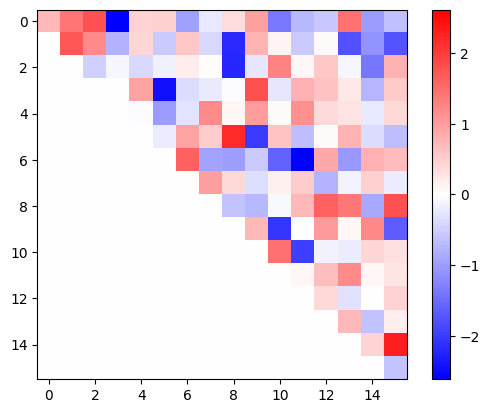

In [6]:
# test

N = 16
P = calc_P_from_N(N)
w = np.random.randn(P)
Q = calc_Q_from_w(w)

visualize_Q(Q)

以上を用いて、写像 $\phi(x)$ を実装する。

In [7]:
def calc_z_from_x(x: np.ndarray) -> np.ndarray:
    N = x.shape[0]
    P = calc_P_from_N(N)
    z = np.zeros(P, dtype=float)

    z[0 : 1]   = 1
    z[1 : 1+N] = x

    i, j       = np.triu_indices(N, k=1)
    z[1+N : P] = x[i] * x[j]

    return z

代理モデルを実装する。学習器は適当に `posterior_sampler: (np.ndarray, np.ndarray) -> np.ndarray` とする。獲得関数はまだ実装しない。

In [8]:
class SurrogateModel:
    def __init__(self, num_features: int, posterior_sampler):
        N = num_features
        P = calc_P_from_N(N)

        w = np.zeros(P, dtype=float)
        self.params  = {'w': w}
        self.posterior_sampler = posterior_sampler

    def get_params(self):
        return self.params

    def predict(self, x: np.ndarray) -> float:
        z = calc_z_from_x(x)
        return z @ self.params['w']

    def fit(self, x_data: np.ndarray, y_data: np.ndarray):
        z_data = np.apply_along_axis(calc_z_from_x, 1, x_data)
        w = self.posterior_sampler(self, z_data, y_data)

        self.params['w'] = w

仮にサンプラーとして最小二乗法を用いてみよう。

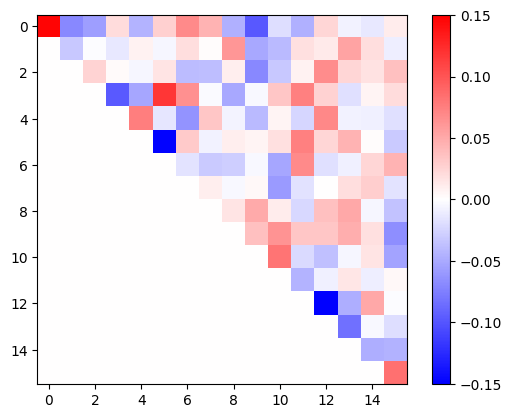

MSE: 0.0010899945846728153


In [9]:
# test

sample_lstsq = lambda _, z, y: np.linalg.lstsq(z, y, rcond=None)[0]

D = 256
N = 16

model = SurrogateModel(16, sample_lstsq)
x_data = np.random.choice([0, 1], size=(D, N))
Q_true = np.triu(np.random.normal(0, 1, size=(N, N)))
y_data = np.einsum('di,ij,dj->d', x_data, Q_true, x_data) + np.random.normal(0, 0.1, size=D)

model.fit(x_data, y_data)
Q_pred = calc_Q_from_w(model.params['w'])

visualize_Q(Q_true - Q_pred)

mse = np.mean((Q_true - Q_pred) ** 2)
print(f"MSE: {mse}")

## 獲得関数

獲得関数にはThompson抽出を用いる。これはパラメータの事後分布に従うサンプルを適用した代理モデルそのものを獲得関数として用いるものである。すなわち

$$
\begin{aligned}
    &&
    \alpha(x)
    &= \hat f(x; \tilde w) = \phi(x)^\top \tilde w \\
    \text{where} &&
    \tilde w &\sim p(w | \mathcal D)
\end{aligned}
$$

まず、事後分布からサンプルを抽出する部分 $w \sim p(\tilde w | \mathcal D)$ を実装する。これには馬蹄事前分布を用いて得られるGibbsサンプラーを用いる。詳細は `SparseBLR.ipynb` に記載されている。実装上以下のように設定したことに注意いただきたい:

1. Gibbsサンプリングにおけるパラメータ $w$ の初期値として直前のモデルのパラメータを使用する
2. それ以外のハイパーパラメータ $\sigma_n^2, \lambda^2, \tau^2, \nu, \xi$ は適当な値に初期化する

ここでは、`BOCS/Horseshoe.jl` 内の実装をインポートして用いる。

In [10]:
dir_bocs = dir_script / 'BOCS'
Main.include(str(dir_bocs / 'horseshoe.jl'))

<PyCall.jlwrap sample_horseshoe_posterior>

In [11]:
class HorseshoeSampler:
    def __init__(self, num_iter: int=50, show_progress: bool = False, use_julia: bool = True):
        self.num_iter      = num_iter
        self.show_progress = show_progress
        self.use_julia     = use_julia

    def __call__(self, x_data: np.ndarray, y_data: np.ndarray, model: SurrogateModel):
        N_data, N_vars = x_data.shape
        params = model.get_params()
        w = params['w']

        sigma2_n = 1.
        lamb2    = np.ones(N_vars).astype(np.float64)
        tau2     = 1.
        nu       = np.ones(N_vars).astype(np.float64)
        xi       = 1.

        if self.use_julia:
            return Main.sample_horseshoe_posterior(
                x_data.astype(np.float64),
                y_data.astype(np.float64),
                w,
                sigma2_n,
                lamb2,
                tau2,
                nu,
                xi,
                self.num_iter,
                self.show_progress,
            )
        else:
            raise NotImplementedError

獲得関数自体は代理モデルの `predict` そのものであるから、単なるエイリアスとして実装する。

In [12]:
def remove_duplicates_and_average(x_data, y_data):
    x_data = x_data.astype(float)
    y_data = y_data.astype(float)

    sorted_indices = np.lexsort(x_data.T)
    x_data = x_data[sorted_indices]
    y_data = y_data[sorted_indices]

    _, unique_indices, counts = np.unique(x_data, axis=0, return_index=True, return_counts=True)
    x_data = x_data[unique_indices]

    # sort x_data again: unique_indices is not sorted
    sorted_indices = np.lexsort(x_data.T)
    x_data = x_data[sorted_indices]

    remove_indices = []
    for unique_index, count in zip(unique_indices, counts):
        if count > 1:
            y_data[unique_index] = np.mean(y_data[unique_index:unique_index+count])
            remove_indices.extend(range(unique_index+1, unique_index+count))
    y_data = np.delete(y_data, remove_indices)

    return x_data, y_data

class SurrogateModel:
    def initialize_params(self, P):
        w = np.zeros(P, dtype=float)
        self.params  = {'w': w}

    def __init__(self, num_features: int, posterior_sampler, preprocess: Optional[Callable] = remove_duplicates_and_average):
        N = num_features
        P = calc_P_from_N(N)

        self.initialize_params(P)
        self.posterior_sampler = posterior_sampler

        self.preprocess = preprocess

    def get_params(self):
        return self.params

    def predict(self, x: np.ndarray) -> float:
        z = calc_z_from_x(x)
        return z @ self.params['w']

    def fit(self, x_data: np.ndarray, y_data: np.ndarray):
        z_data = np.apply_along_axis(calc_z_from_x, 1, x_data)

        if self.preprocess is not None:
            z_data, y_data = self.preprocess(z_data, y_data)

        w = self.posterior_sampler(z_data, y_data, self)

        self.params['w'] = w

    def acquisition_function(self, x_data: np.ndarray) -> float:
        return self.predict(x_data)

線形回帰モデルの事後サンプリングは `x_data` と `y_data` の両方が完全に一致する行が存在すると逆行列計算やCholesky分解が正常に実行されずバグる。それを回避するため、重複した `x_data` を削除し、対応する `y_data` を平均化する `remove_duplicates_and_average()` を追加した。

獲得関数が実装できたので、あとはこれを最小化するためのソルバーを実装しよう。ここでは焼きなまし法 (SA) を用いる。

In [13]:
def simulated_annealing_sampler(
    state_init: np.ndarray,
    energy_func: Callable,
    beta_schedule: Callable,
    proposer: Callable,
    t_all: int,
    show_progress: bool=False,
    seed: Optional[int]=None
):
    rng = np.random.default_rng(seed)
    state_current = state_init
    energy_current = energy_func(state_current)

    state_best  = state_current
    energy_best = energy_current

    iter_base = int(np.log10(t_all) + 1)

    for t in range(t_all):
        beta = beta_schedule(t, t_all)
        state_new    = proposer(state_current)
        energy_new   = energy_func(state_new)
        delta_energy = energy_new - energy_current

        if delta_energy < 0 or np.exp(-beta * delta_energy) > rng.uniform(0, 1):
            state_current  = state_new
            energy_current = energy_new

            if energy_current < energy_best:
                state_best  = state_current
                energy_best = energy_current

        if show_progress and (t % 100) == 0:
            print(f'iter {t:{iter_base}d}: {energy_best}')

    return state_best

class SimulatedAnnealingSampler:
    def __init__(self, proposer, beta_schedule, t_all, show_progress=False, seed=None):
        self.proposer      = proposer
        self.beta_schedule = beta_schedule
        self.t_all         = t_all

        self.show_progress = show_progress
        self.rng           = np.random.default_rng(seed)

        self.state = None

    def sample(self, state_init, energy_func):
        self.state = simulated_annealing_sampler(
            state_init,
            energy_func,
            self.beta_schedule,
            self.proposer,
            self.t_all,
            self.show_progress
        )

class ExponentialCooling:
    def __init__(self, beta_init=1e-3, beta_final=1e3):
        self.beta_init  = beta_init
        self.beta_final = beta_final

    def __call__(self, t: int, t_all: int) -> float:
        beta = self.beta_init * (self.beta_final / self.beta_init) ** (t / (t_all - 1))
        return beta

def propose_binary(state_current, seed=None):
    rng = np.random.default_rng(seed)
    N = len(state_current)
    idx = rng.integers(low=0, high=N)
    state_new = state_current.copy()
    state_new[idx] = 1 - state_new[idx]
    return state_new

class AcquisitionFunctionOptimizer:
    def __init__(self, sampler, initializer):
        self.sampler     = sampler
        self.initializer = initializer
        self.state       = None

    def optimize(self, acquisition_function, x_data, y_data):
        state_init = self.initializer()
        self.sampler.sample(state_init, acquisition_function)
        self.state = self.sampler.state

In [14]:
# test

N = 16
D = 32

surrogate_model = SurrogateModel(
    num_features=N,
    posterior_sampler=HorseshoeSampler(
        num_iter     =5,
        show_progress=True,
        use_julia    =True
    )
)

acquis_optimizer = AcquisitionFunctionOptimizer(
    sampler = SimulatedAnnealingSampler(
        proposer     =propose_binary,
        beta_schedule=ExponentialCooling(1e-3, 1e3),
        t_all        =2000,
        show_progress=True
    ),
    initializer = lambda: np.random.choice([0, 1], size=N)
)

x_data = np.random.choice([0, 1], size=(D, N))
Q_true = np.triu(np.random.normal(0, 1, size=(N, N)))
y_data = np.einsum('di,ij,dj->d', x_data, Q_true, x_data) + np.random.normal(0, 0.1, size=D)

print("-"*20)
print("training the surrogate model")
print("-"*20)
surrogate_model.fit(x_data, y_data)

print("-"*20)
print("sampling from the acquisition function")
print("-"*20)
acquis_optimizer.optimize(surrogate_model.acquisition_function, x_data, y_data)

x_next = acquis_optimizer.state
y_next = np.einsum('i,ij,j->', x_next, Q_true, x_next) + np.random.normal(0, 0.1)

print(f"x_next: {x_next}")
print(f"y_next: {y_next}")

--------------------
training the surrogate model
--------------------
--------------------
sampling from the acquisition function
--------------------
Iteration 1: 0.8191091058412472
Iteration 2: 0.7458216124672272
Iteration 3: 0.7684554988781072
Iteration 4: 1.0044917704183352
Iteration 5: 0.5040459849074315
iter    0: -7.935909819097686
iter  100: -14.6666350909627
iter  200: -14.876649095937095
iter  300: -14.876649095937095
iter  400: -14.876649095937095
iter  500: -14.876649095937095
iter  600: -14.876649095937095
iter  700: -14.921389509465719
iter  800: -14.921389509465719
iter  900: -17.448673175079648
iter 1000: -17.448673175079648
iter 1100: -18.60347377468956
iter 1200: -18.60347377468956
iter 1300: -18.60347377468956
iter 1400: -18.60347377468956
iter 1500: -18.60347377468956
iter 1600: -18.60347377468956
iter 1700: -18.60347377468956
iter 1800: -18.60347377468956
iter 1900: -18.60347377468956
x_next: [1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1]
y_next: -16.79127348880696


## 反復を回す

以上実装された各要素を用いてベイズ最適化を実現する。まずはベイズ最適化全体を実装しよう。

In [15]:
def make_monotonically_decreasing(series):
    series_decreasing = series.copy()
    for i in range(1, len(series_decreasing)):
        series_decreasing[i] = min(series_decreasing[i], series_decreasing[i-1])
    return series_decreasing

def show_current_progress(fig, y_best_list, y_data, y_stop_criterion, N):
    clear_output(wait = True)
    if y_stop_criterion > -np.inf:
        y_best_list = np.array(y_best_list - y_stop_criterion) / N
        y_data = np.array(y_data - y_stop_criterion) / N
    plt.cla()
    plt.plot(range(len(y_best_list)), y_best_list, color='b')
    plt.scatter(range(len(y_data)), y_data, c='r', marker='x')
    plt.grid()
    display(fig)

class BayesianOptimizer:
    def __init__(self, objective_function, surrogate_model, acquis_optimizer):
        self.objective_function = objective_function
        self.surrogate_model    = surrogate_model
        self.acquis_optimizer   = acquis_optimizer

    def sample(self, x_data_init: list[np.ndarray], y_data_init: list[float], num_iter: int, y_stop_criterion: float = -np.inf):
        x_data = x_data_init
        y_data = y_data_init
        y_best_list = make_monotonically_decreasing(y_data)

        fig = plt.figure()
        iter_base = int(np.log10(num_iter) + 1)

        while len(y_data) < num_iter:
            self.surrogate_model.fit(np.array(x_data), np.array(y_data))

            self.acquis_optimizer.optimize(
                self.surrogate_model.acquisition_function, x_data, y_data
            )

            x_next = self.acquis_optimizer.state
            y_next = self.objective_function(x_next)

            x_data.append(x_next)
            y_data.append(y_next)

            if y_next < y_best_list[-1]:
                y_best_list.append(y_next)
            else:
                y_best_list.append(y_best_list[-1])

            show_current_progress(fig, y_best_list, y_data, y_stop_criterion, N)

            # i = len(y_data)
            # print(f"iter {i+1:{iter_base}d} | {num_iter:{iter_base}d} | y_best: {y_best_list[-1]:.6f} | y_stop: {y_stop_criterion}")

            if np.isclose(y_best_list[-1], y_stop_criterion):
                break
            if (y_best_list[-1] - y_stop_criterion) / N <= 1e-3:
                break

        return x_data, y_data, self.surrogate_model.params

In [16]:
D_init = 16
N = 16

def objective_function(x: np.ndarray) -> float:
    return np.einsum('i,ij,j->', x, Q_true, x)

surrogate_model = SurrogateModel(
    num_features=N,
    posterior_sampler=HorseshoeSampler(
        num_iter     =100,
        show_progress=False
    )
)

acquis_optimizer = AcquisitionFunctionOptimizer(
    sampler=SimulatedAnnealingSampler(
        proposer     =propose_binary,
        beta_schedule=ExponentialCooling(1e-3, 1e3),
        t_all        =2500,
        show_progress=False
    ),
    initializer=lambda: np.random.choice([0, 1], size=N)
)

bayesian_optimizer = BayesianOptimizer(
    objective_function=objective_function,
    surrogate_model   =surrogate_model,
    acquis_optimizer  =acquis_optimizer
)

x_data = [np.random.choice([0, 1], size=(N)) for _ in range(D_init)]
y_data = [objective_function(x) for x in x_data]

実行前に、SAを用いて端的に近似解を求めておく。

In [17]:
sa_sampler = SimulatedAnnealingSampler(
    proposer     =propose_binary,
    beta_schedule=ExponentialCooling(1e-3, 1e3),
    t_all        =12000,
    show_progress=False
)

x_init = np.random.choice([0, 1], size=N)
sa_sampler.sample(x_init, objective_function)

x_sa = sa_sampler.state
y_sa = objective_function(x_sa)

print(f"x_sa: {x_sa}")
print(f"y_sa: {y_sa}")

x_sa: [1 0 1 1 1 1 1 0 1 1 0 0 0 1 1 1]
y_sa: -22.182391303153594


ここでは、とりあえずこの解をベイズ最適化の停止基準としておく。ただしこれができるのは、今回はたまたま目的関数 $f(x) = x^\top Q x$ がSAによるサンプリングが容易な問題であるからだということに注意が必要。通常、ベイズ最適化で扱う問題はSAで解くのは難しいからこそ、わざわざ代理モデルで近似してからSAを実行するのである。ここんとこ勘違いしないように。

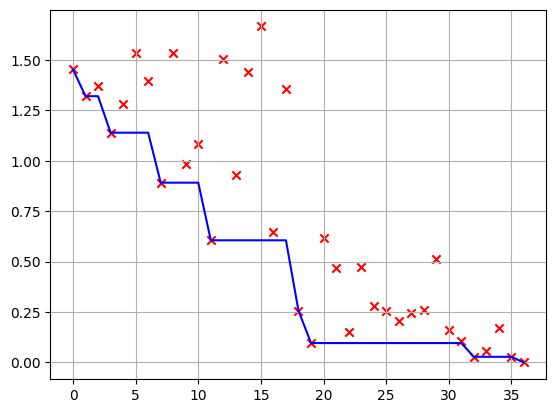

CPU times: user 3.11 s, sys: 92.2 ms, total: 3.2 s
Wall time: 2.65 s


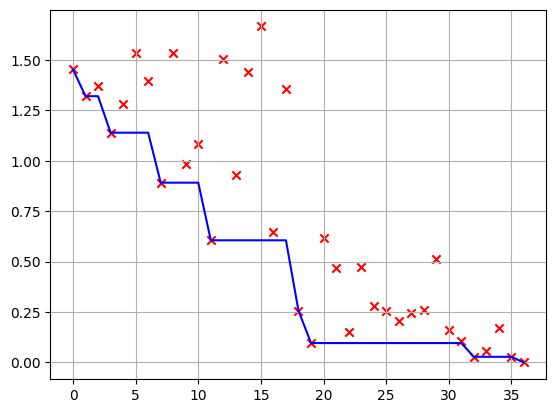

In [18]:
%%time

x_data_end, y_data_end, params_end = bayesian_optimizer.sample(x_data, y_data, num_iter=256, y_stop_criterion=y_sa)

最終的なパラメータは `params_end' に格納した。この中身を図示してみよう。

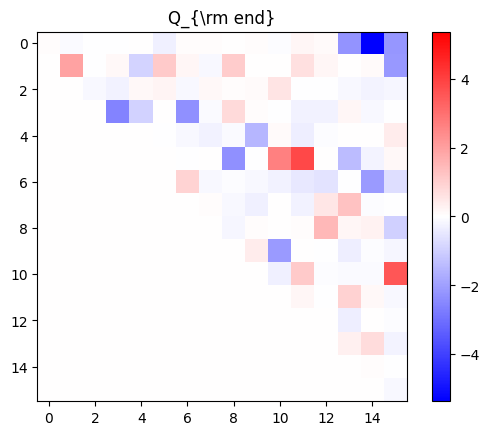

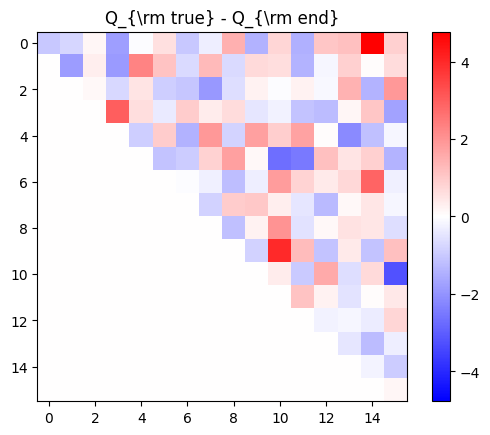

In [19]:
Q_end = calc_Q_from_w(params_end['w'])

plt.title(r'Q_{\rm end}')
visualize_Q(Q_end)

plt.title(r'Q_{\rm true} - Q_{\rm end}')
visualize_Q(Q_true - Q_end)

## おまけ

ここからはオマケ。今回の場合目的関数にノイズが付加されない想定なので、全く同一の点の複数サンプルは全く意味がない。そこで完全に一致する解が出てきたらランダムにぶっ飛ばしてしまう後処理 [Morita+ 2023] を追加する。

In [20]:
POSTPROCESS_MAX_TRIAL = 100

def is_known(x, x_data):
    return np.any(np.all(x_data == x, axis=1))

def random_postprocess(x, x_data, max_trial=POSTPROCESS_MAX_TRIAL):
    x_current = x.copy()
    for trial in range(max_trial):
        if is_known(x, x_data):
            x_current = np.random.choice([0, 1], size=x_current.shape)
    return x_current

class AcquisitionFunctionOptimizerWithPostprocess(AcquisitionFunctionOptimizer):
    def optimize(self, acquisition_function, x_data, y_data):
        state_init = self.initializer()
        self.sampler.sample(state_init, acquisition_function)
        self.state = self.sampler.state
        self.state = random_postprocess(self.state, x_data)

In [21]:
acquis_optimizer_with_postprocess = AcquisitionFunctionOptimizerWithPostprocess(
    sampler=SimulatedAnnealingSampler(
        proposer     =propose_binary,
        beta_schedule=ExponentialCooling(1e-3, 1e3),
        t_all        =2500,
        show_progress=False
    ),
    initializer=lambda: np.random.choice([0, 1], size=N)
)

bayesian_optimizer = BayesianOptimizer(
    objective_function=objective_function,
    surrogate_model   =surrogate_model,
    acquis_optimizer  =acquis_optimizer_with_postprocess
)

x_data = [np.random.choice([0, 1], size=(N)) for _ in range(D_init)]
y_data = [objective_function(x) for x in x_data]

In [22]:
sa_sampler = SimulatedAnnealingSampler(
    proposer     =propose_binary,
    beta_schedule=ExponentialCooling(1e-3, 1e3),
    t_all        =12000,
    show_progress=False
)

x_init = np.random.choice([0, 1], size=N)
sa_sampler.sample(x_init, objective_function)

x_sa = sa_sampler.state
y_sa = objective_function(x_sa)

print(f"x_sa: {x_sa}")
print(f"y_sa: {y_sa}")

x_sa: [1 0 1 1 1 1 1 0 1 1 0 0 0 1 1 1]
y_sa: -22.182391303153594


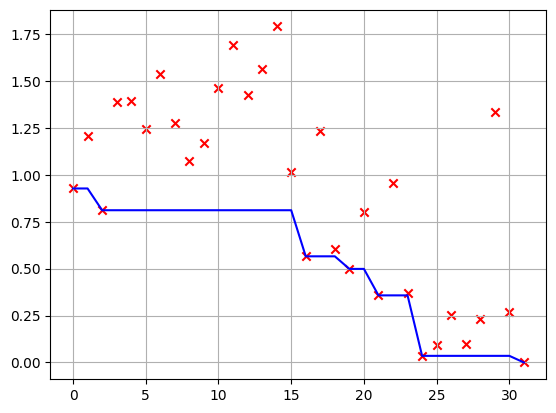

CPU times: user 2.5 s, sys: 67.2 ms, total: 2.57 s
Wall time: 2.03 s


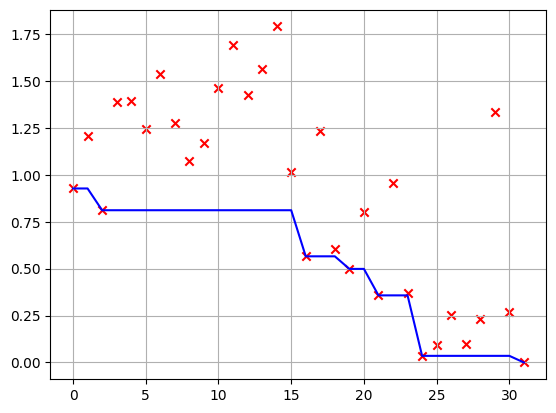

In [23]:
%%time

x_data_end, y_data_end, params_end = bayesian_optimizer.sample(x_data, y_data, num_iter=256, y_stop_criterion=y_sa)